In [1]:
import numpy as np
from Utils import *
import matplotlib.pyplot as plt
from numba import njit
import seaborn as sns

import numba as nb
from tqdm import tqdm as tqdm

In [2]:
# Simulation Parameters

E_inputs = 200
I_inputs = 50
Groups = 10


time = 180000 # ms
dt = 0.1 # ms
timesteps=int(time/dt)
pulse_time = 200
tau = 2.0
    
noise = 0.01
dendrite_leak = -0.01

In [3]:
# Dendritic structure

num_dend = Groups

re = 0.9999
ri = 0.9999

W_dend_E = get_input_matrix(num_dend, E_inputs, re)
W_dend_I = get_input_matrix(num_dend, I_inputs, ri)

In [4]:
# Plasticity parameters

eta_e = 0.001
e_target = 5.0

eta_i = 0.002
i_target = 1.5

In [5]:
# Get Inputs
E_currents, I_currents, angle = get_EI_input(noise = noise,
                                             E_inputs = E_inputs,
                                             I_inputs = I_inputs,
                                             Groups = Groups,
                                             scale = 0.5,
                                             pulse_time = pulse_time,
                                             time = time,
                                             dt = dt,
                                            I_delay = 0)

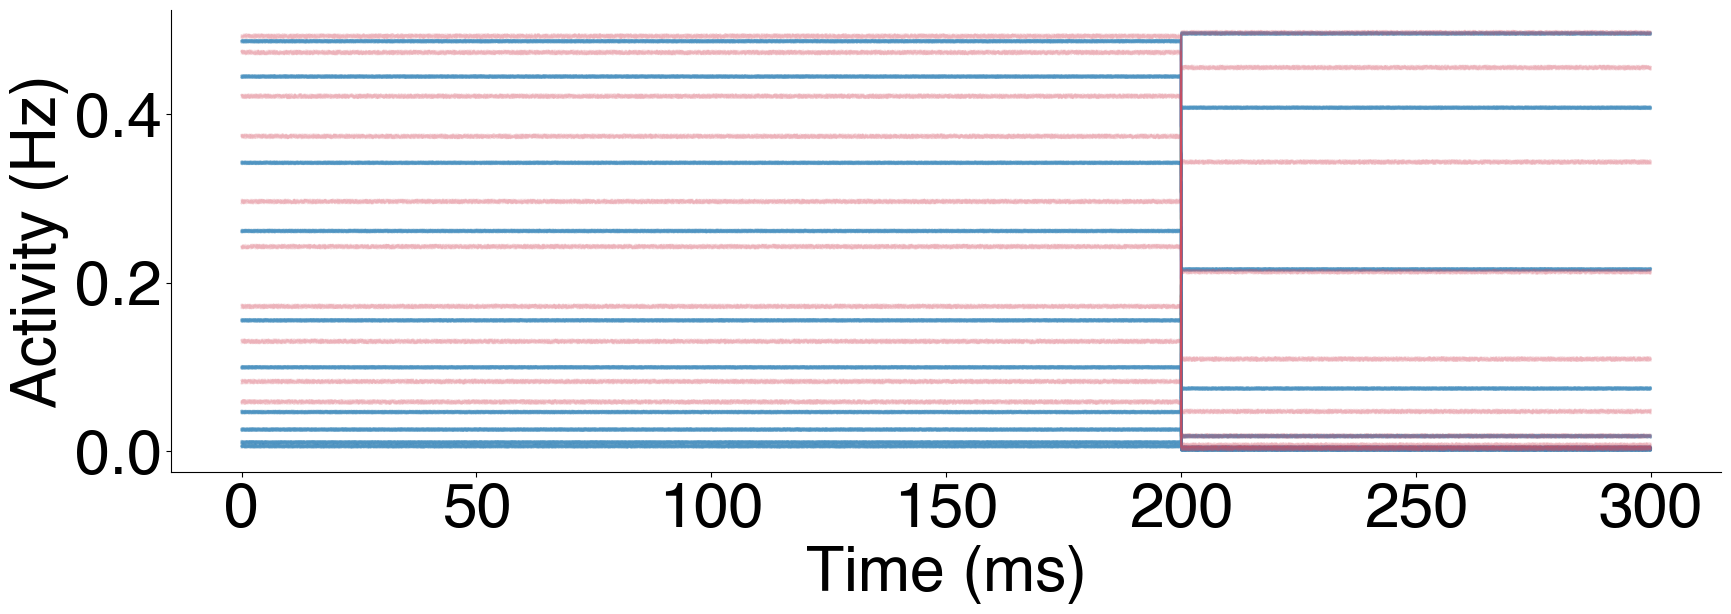

In [6]:
plt.rcParams.update({'font.size': 45})

plt.figure(figsize= (20, 6))
plt.plot(np.linspace(0, 300, 3000), E_currents[0:3000, 0:200], color = '#3d8bbeff', alpha = 0.1);
plt.plot(np.linspace(0, 300, 3000),I_currents[0:3000, 0:50], color = '#d74c5eff', alpha = 0.1);

plt.xlabel('Time (ms)')
plt.ylabel('Activity (Hz)')

sns.despine()

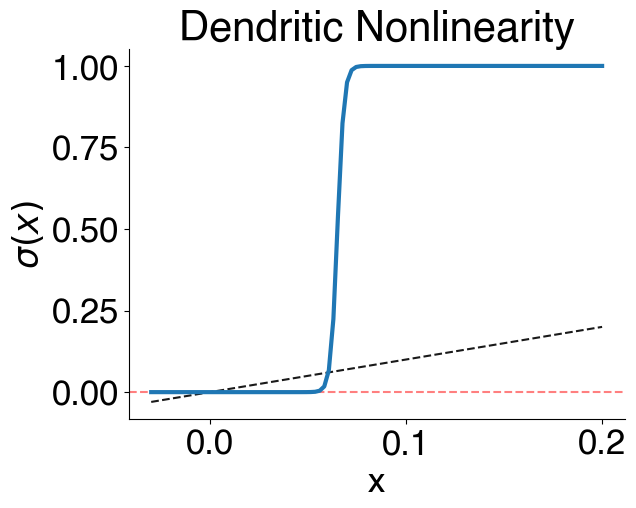

In [ ]:
plt.rcParams.update({'font.size': 25})

params = np.array([0.0, 1.0, 1.0, 1.0, -600, 0.065])

x = np.linspace(-0.03, 0.2, 100)

plt.plot(x, x, '--k', alpha = 0.9)
plt.axhline(y = 0, linestyle = '--', color = 'r', alpha = 0.5)

plt.plot(x, non_lin(x, nonlin=True, params=params), linewidth = 3)

plt.xlabel('x')
plt.ylabel(r'$\sigma(x)$')
plt.title('Dendritic Nonlinearity')

sns.despine()

In [8]:
#### Simulation ####

@nb.njit
def simulate(timesteps=int(time/dt)):

    r = np.zeros(timesteps)
    v = np.zeros(timesteps)
    r[0] = 0.01
    v = 0.25

    w_e = e_target * np.random.rand(timesteps, E_inputs) / E_inputs
    w_i = i_target * np.random.rand(timesteps, I_inputs) / I_inputs

    E_target = e_target * np.ones(timesteps)

    # Simulate learning
    for t in range(1, timesteps-1):
        x = (w_e[t] * E_currents[t])@W_dend_E - (w_i[t] * I_currents[t])@W_dend_I + dendrite_leak * v
        inp = np.sum(non_lin(x, nonlin=False, params=params))

        delta_v = -v / tau + inp
        v = v + dt * delta_v
        r[t] = rate(v)

        # STDP
        w_e[t+1] = np.maximum(w_e[t] + dt * eta_e * stdp(E_currents[t], r[t]), 0)
        w_i[t+1] = np.maximum(w_i[t] + dt * eta_i * stdp(I_currents[t], r[t]), 0)

        # Meta-Plasticity
        E_target[t+1] = E_target[t] - 0.25*eta_e*dt*(r[t] - r[0])

        # Normalization
        w_e[t+1] = w_e[t+1] * E_target[t+1] / np.sum(w_e[t+1])
        w_i[t+1] = w_i[t+1] * i_target / np.sum(w_i[t+1])

    return w_e, w_i, r, E_target

In [9]:
w_e, w_i, r, E_target = simulate()

In [10]:
get_losses(w_e, w_i)

(0.008154961962733721, 0.038436996160955306, 0.00010627286282961479)

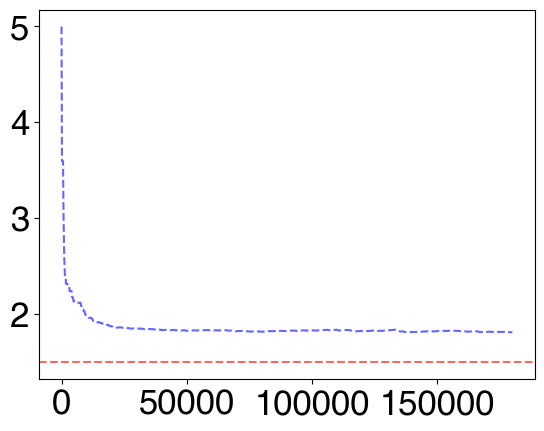

In [11]:
plt.plot(np.linspace(0, time, timesteps), E_target, '--b', alpha = 0.6);
plt.axhline(y = i_target, linestyle ='--', color = 'r', alpha = 0.6);

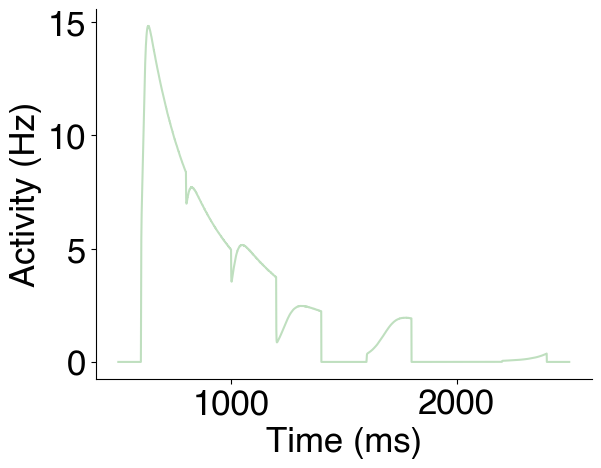

In [12]:
plt.plot(np.linspace(0, time, timesteps-1)[5000:25000], r[5000:25000], color = 'g', alpha = 0.25);
plt.xlabel('Time (ms)')
plt.ylabel('Activity (Hz)')
sns.despine()

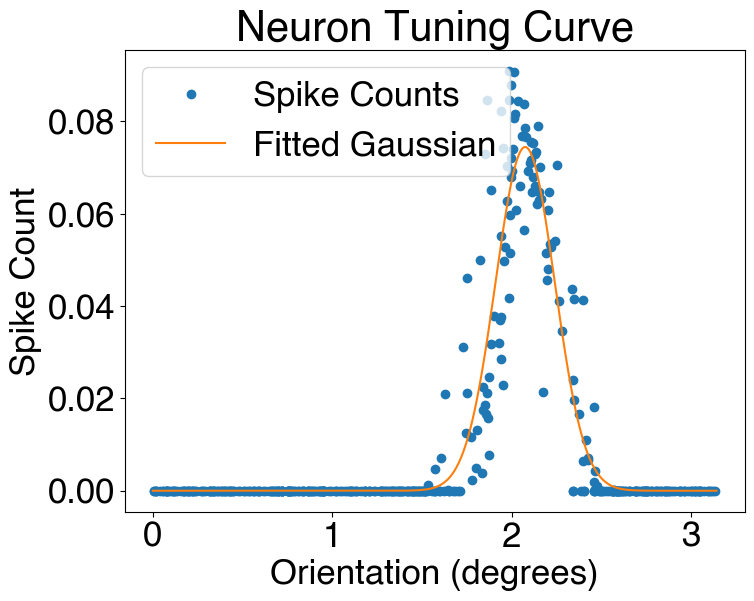

Fitted Parameters: A=0.07439917011101478, mu=2.0751981417911063, sigma=0.1651387173585755


In [13]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))

l = int(len(angle)//2)
x = angle[-l:]
y = np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:]
    

popt, pcov = curve_fit(gaussian, x, y,
                       p0=[0.05, 1.570, 0.3490], 
                       maxfev = 150000)
A, mu, sigma = popt

# Generate data using the fitted parameters
x_fit = np.linspace(0, np.pi, 1000)
y_fit = gaussian(x_fit, A, mu, sigma)

plt.figure(figsize=(8, 6))
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:], 'o', label='Spike Counts')
plt.plot(x_fit, y_fit, '-', label='Fitted Gaussian')
# plt.plot(x_fit, y_act, '.', color = 'g')
plt.xlabel('Orientation (degrees)')
plt.ylabel('Spike Count')
plt.title('Neuron Tuning Curve')
plt.legend()
plt.show()

print(f'Fitted Parameters: A={A}, mu={mu}, sigma={sigma}')

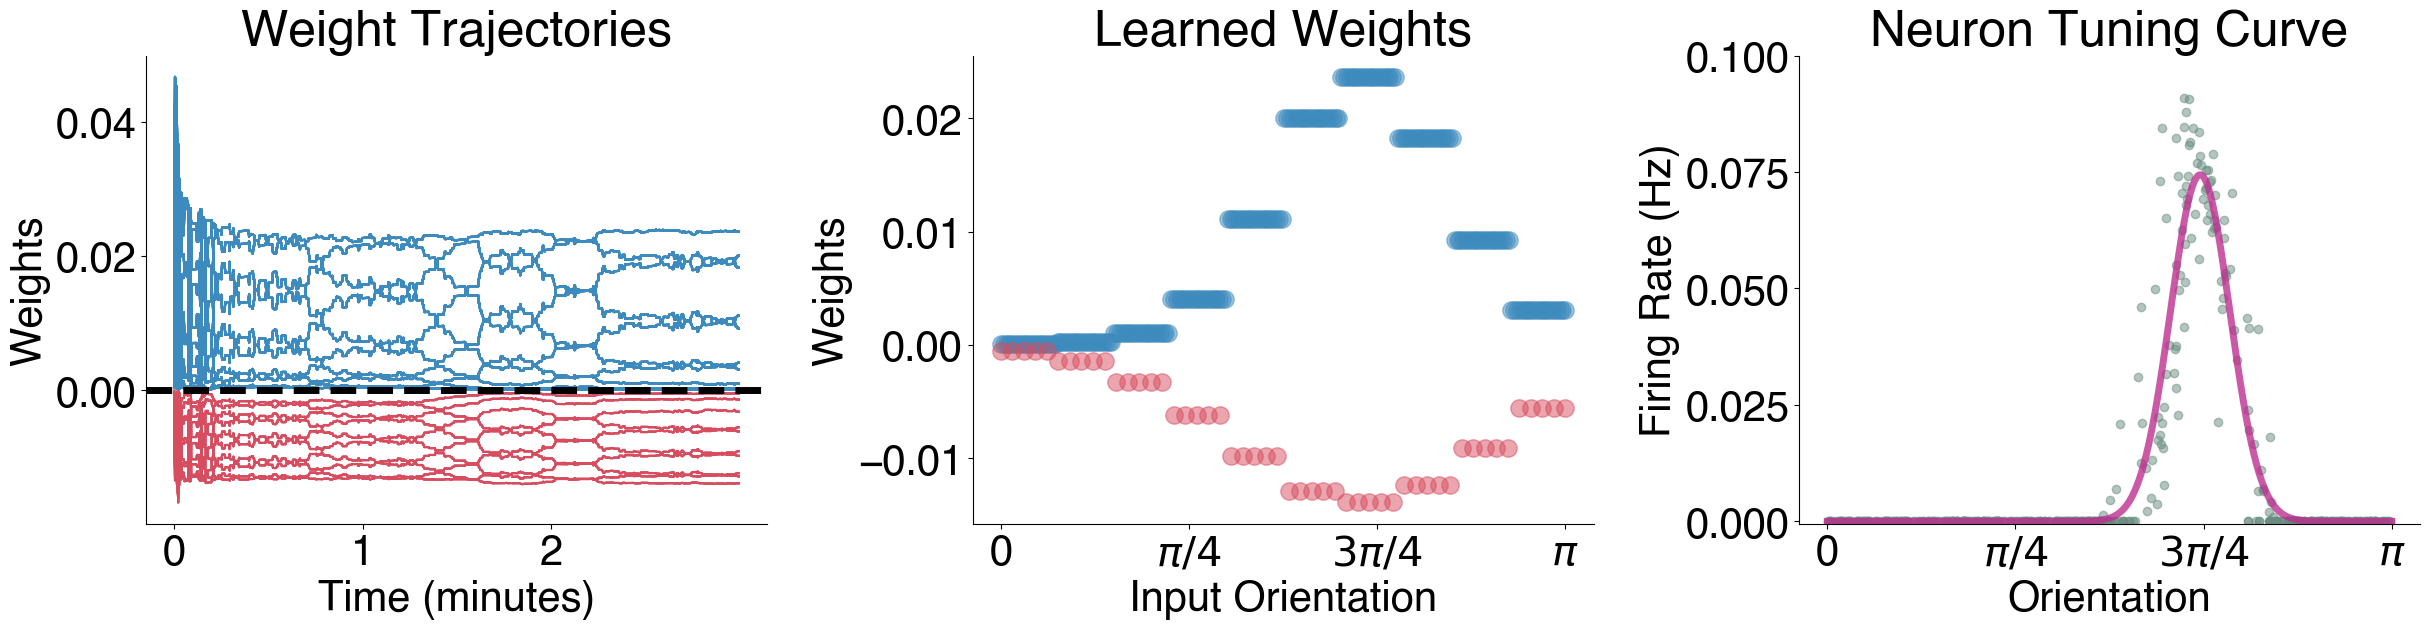

In [14]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize= (25, 7))


plt.subplot(1, 3, 1)
plt.plot(np.linspace(0, time, timesteps)[::2000], w_e[::2000], color = '#3d8bbeff', alpha = 0.8);
plt.plot(np.linspace(0, time, timesteps)[::2000], -w_i[::2000]/4, color = '#d74c5eff', alpha = 0.8);
plt.axhline(y = 0, linestyle = "--", linewidth = 5.0, color = 'k')
plt.xticks([0, 60000, 120000], ['0', '1', '2'])
plt.xlabel('Time (minutes)')
plt.ylabel('Weights')
plt.title('Weight Trajectories')
sns.despine()

plt.subplot(1, 3, 2)
plt.plot(np.linspace(0, 100, E_inputs), w_e[-1], '.', markersize = 25, color = '#3d8bbeff', alpha = 0.5)
plt.plot(np.linspace(0, 100, I_inputs), -w_i[-1]/4, '.', markersize = 25, color = '#d74c5eff', alpha = 0.5)
plt.xlabel('Input Orientation')
plt.xticks(np.linspace(0, 100, 4), ['0', r'$\pi/4$', r'$3\pi/4$', r'$\pi$'])
plt.ylabel('Weights')
plt.title('Learned Weights')


plt.subplot(1, 3, 3)
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:],
         'o',
         label='FR',
         color = '#688c7eca', alpha = 0.5)
plt.plot(x_fit, y_fit, '-', label='Gaussian', color = '#bc2d8fca', linewidth = 5)
plt.xticks(np.linspace(0, np.pi, 4), ['0', r'$\pi/4$', r'$3\pi/4$', r'$\pi$'])
plt.xlabel('Orientation')
plt.ylabel('Firing Rate (Hz)')
plt.title('Neuron Tuning Curve')
plt.ylim([-0.0005, 0.1])
sns.despine()

plt.tight_layout()

In [15]:
X = np.linspace(0, 100, 100)

np.roll(X, 10)

array([ 90.90909091,  91.91919192,  92.92929293,  93.93939394,
        94.94949495,  95.95959596,  96.96969697,  97.97979798,
        98.98989899, 100.        ,   0.        ,   1.01010101,
         2.02020202,   3.03030303,   4.04040404,   5.05050505,
         6.06060606,   7.07070707,   8.08080808,   9.09090909,
        10.1010101 ,  11.11111111,  12.12121212,  13.13131313,
        14.14141414,  15.15151515,  16.16161616,  17.17171717,
        18.18181818,  19.19191919,  20.2020202 ,  21.21212121,
        22.22222222,  23.23232323,  24.24242424,  25.25252525,
        26.26262626,  27.27272727,  28.28282828,  29.29292929,
        30.3030303 ,  31.31313131,  32.32323232,  33.33333333,
        34.34343434,  35.35353535,  36.36363636,  37.37373737,
        38.38383838,  39.39393939,  40.4040404 ,  41.41414141,
        42.42424242,  43.43434343,  44.44444444,  45.45454545,
        46.46464646,  47.47474747,  48.48484848,  49.49494949,
        50.50505051,  51.51515152,  52.52525253,  53.53

In [16]:
from sklearn.metrics import r2_score

# Calculate the R-squared value
r_squared = r2_score(np.mean(r.reshape(-1, int(100/dt)), axis=1)[-l:], gaussian(angle[-l:], *popt))
print(f'R-squared: {r_squared}')

R-squared: -0.999099487272088


In [17]:
def activation(x, y):
    return np.exp(-((x-y)**2)/(2*(np.pi/9)**2))


y_act = A*activation(mu, x_fit)


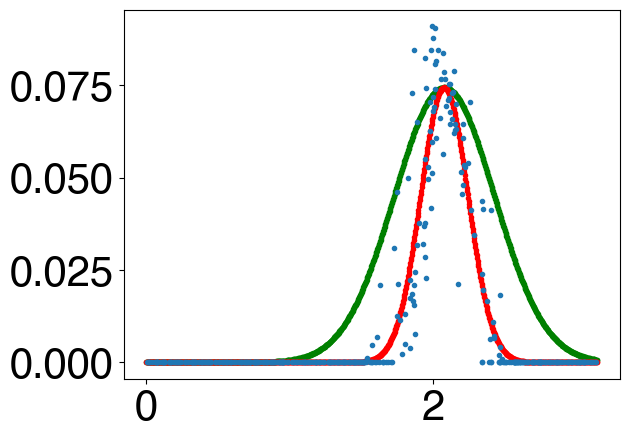

In [18]:
plt.plot(x_fit, y_act, '.', color = 'g')
plt.plot(x_fit, y_fit, '.', color = 'r')
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:], '.')


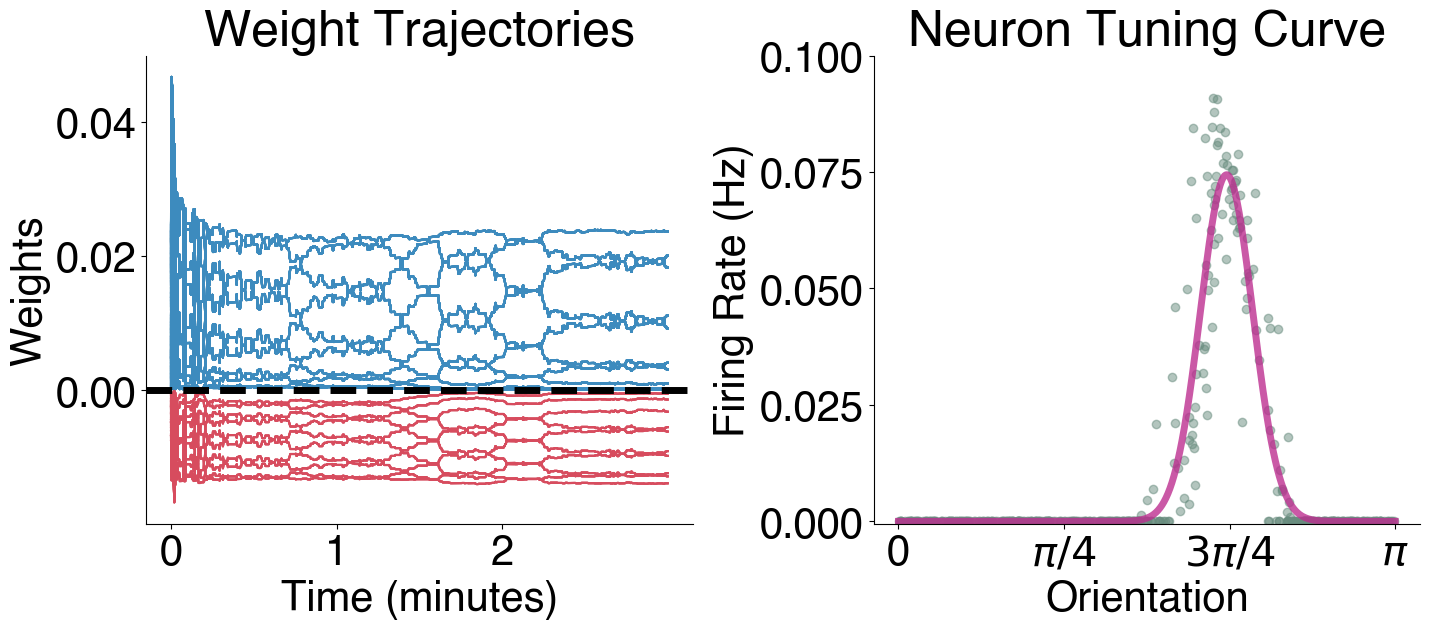

In [19]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize= (15, 7))


plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, time, timesteps)[::2000], w_e[::2000], color = '#3d8bbeff', alpha = 0.8);
plt.plot(np.linspace(0, time, timesteps)[::2000], -w_i[::2000]/4, color = '#d74c5eff', alpha = 0.8);
plt.axhline(y = 0, linestyle = "--", linewidth = 5.0, color = 'k')
plt.xticks([0, 60000, 120000], ['0', '1', '2'])
plt.xlabel('Time (minutes)')
plt.ylabel('Weights')
plt.title('Weight Trajectories')
sns.despine()

plt.subplot(1, 2, 2)
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:],
         'o',
         label='FR',
         color = '#688c7eca', alpha = 0.5)
plt.plot(x_fit, y_fit, '-', label='Gaussian', color = '#bc2d8fca', linewidth = 5)
plt.xticks(np.linspace(0, np.pi, 4), ['0', r'$\pi/4$', r'$3\pi/4$', r'$\pi$'])
plt.xlabel('Orientation')
plt.ylabel('Firing Rate (Hz)')
plt.title('Neuron Tuning Curve')
plt.ylim([-0.0005, 0.1])
sns.despine()

plt.tight_layout()